In [1]:
from datetime import datetime
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.model_selection import GridSearchCV
from prettytable import PrettyTable
from textwrap import wrap
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing import text
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization, GRU ,concatenate
import tensorflow as tf
import unicodedata
import base64
import nltk
nltk.download('punkt')
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
VAL_WRAP_WIDTH = 60

%matplotlib inline
timer_initial = datetime.now()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sujau\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
import re
import pickle
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score

%matplotlib inline
timer_initial = datetime.now()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sujau\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Data Extraction

### 1.1 Setting up properties

In [2]:
f_path = '../datasets/Stack Overflow/'
train = 'Train.csv'
test = 'Test.csv'
chunk_size = 400000 # 0.4 million observations w.r.t. my machine capacity

### 1.2 Read data from CSV files

In [3]:
timer = datetime.now()
train_Stk_Ovrfl_df = pd.read_csv(f_path+train, sep=',', encoding='latin-1')
print("Time taken: ", datetime.now() - timer)
train_Stk_Ovrfl_df.head()

Time taken:  0:02:04.643248


,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [4]:
train_Stk_Ovrfl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6034195 entries, 0 to 6034194
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Title   object
 2   Body    object
 3   Tags    object
dtypes: int64(1), object(3)
memory usage: 184.1+ MB


In [5]:
# test_Stk_Ovrfl_df = pd.read_csv(f_path+test, sep=',', encoding='latin-1')
# test_Stk_Ovrfl_df.head()

## 2. Data Exploration

### 2.1 Remove Duplicates

In [6]:
timer = datetime.now()

train_Stk_Ovrfl_df.drop_duplicates()
print("Time taken: ", datetime.now() - timer)

Time taken:  0:01:05.562747


In [7]:
timer = datetime.now()

duplicates_train_Stk_Ovrfl_df = train_Stk_Ovrfl_df[train_Stk_Ovrfl_df.duplicated(['Title','Body','Tags'])]
print("Time taken: ", datetime.now() - timer)
duplicates_train_Stk_Ovrfl_df.info()

Time taken:  0:00:59.908586
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1827881 entries, 3550 to 6034193
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Title   object
 2   Body    object
 3   Tags    object
dtypes: int64(1), object(3)
memory usage: 69.7+ MB


In [8]:
duplicates_train_Stk_Ovrfl_df.head()

,Id,Title,Body,Tags
3550,3551,Compatibility issues with <a> and calling a fu...,<p>I am new to javascript. I wrote the followi...,function anchor
5246,5247,Using JTA with Spring +hibernate JPA+Glassfish...,<p>I have been struggling with this issues and...,spring hibernate jpa glassfish jta
9968,9969,Groovy Properties Assertion Fails,<p>Here is the content of my groovy file:</p>\...,properties groovy assert
10597,10598,Importance of isomorphic functions,<p><strong>Short Question:</strong> What is th...,functional-programming isomorphism
10939,10940,VB6 Form.Show is not working,<p>I have a project with graphs that can be pr...,forms vb6


In [9]:
duplicates_train_Stk_Ovrfl_df[duplicates_train_Stk_Ovrfl_df.Id == 3551]

,Id,Title,Body,Tags
3550,3551,Compatibility issues with <a> and calling a fu...,<p>I am new to javascript. I wrote the followi...,function anchor


In [10]:
print(duplicates_train_Stk_Ovrfl_df[duplicates_train_Stk_Ovrfl_df.Title.str.contains('Compatibility issues with <a> and calling a fu')])

              Id                                              Title  \
3550        3551  Compatibility issues with <a> and calling a fu...   
1851883  1851884  Compatibility issues with <a> and calling a fu...   

                                                      Body             Tags  
3550     <p>I am new to javascript. I wrote the followi...  function anchor  
1851883  <p>I am new to javascript. I wrote the followi...  function anchor  


In [11]:
print(train_Stk_Ovrfl_df[train_Stk_Ovrfl_df.Title.str.contains('Compatibility issues with <a> and calling a fu')])

              Id                                              Title  \
2382        2383  Compatibility issues with <a> and calling a fu...   
3550        3551  Compatibility issues with <a> and calling a fu...   
1851883  1851884  Compatibility issues with <a> and calling a fu...   

                                                      Body             Tags  
2382     <p>I am new to javascript. I wrote the followi...  function anchor  
3550     <p>I am new to javascript. I wrote the followi...  function anchor  
1851883  <p>I am new to javascript. I wrote the followi...  function anchor  


In [12]:
duplicate_percenatge = ((duplicates_train_Stk_Ovrfl_df.shape[0])/train_Stk_Ovrfl_df.shape[0])*100
print("Percentage of duplicate questions: {}%".format(duplicate_percenatge) )

Percentage of duplicate questions: 30.29204392632323%


In [13]:
train_Stk_Ovrfl_df = train_Stk_Ovrfl_df.drop(duplicates_train_Stk_Ovrfl_df.index)
train_Stk_Ovrfl_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4206314 entries, 0 to 6034194
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Title   object
 2   Body    object
 3   Tags    object
dtypes: int64(1), object(3)
memory usage: 160.5+ MB


In [14]:
timer = datetime.now()

duplicates_train_Stk_Ovrfl_df = train_Stk_Ovrfl_df[train_Stk_Ovrfl_df.duplicated(['Title','Body','Tags'])]
duplicate_percentage = ((duplicates_train_Stk_Ovrfl_df.shape[0])/train_Stk_Ovrfl_df.shape[0])*100
print("Percentage of duplicate questions: {}%".format(duplicate_percentage))
print("Time taken: ", datetime.now() - timer)

Percentage of duplicate questions: 0.0%
Time taken:  0:00:45.365283


In [15]:
duplicates_train_Stk_Ovrfl_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      0 non-null      int64 
 1   Title   0 non-null      object
 2   Body    0 non-null      object
 3   Tags    0 non-null      object
dtypes: int64(1), object(3)
memory usage: 0.0+ bytes


In [16]:
# temp_train_Stk_Ovrfl_df = train_Stk_Ovrfl_df.copy()

In [17]:
train_Stk_Ovrfl_df.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


### 2.2 Drop Nulls

In [18]:
train_Stk_Ovrfl_df = train_Stk_Ovrfl_df.dropna()

### 2.3 Tag Analysis

In [19]:
timer = datetime.now()

train_Stk_Ovrfl_df["Tag Count"] = train_Stk_Ovrfl_df["Tags"].apply(lambda x: len(str(x).split(" ")))
print("Time taken: ", datetime.now() - timer)
train_Stk_Ovrfl_df.head()

Time taken:  0:00:03.968898


,Id,Title,Body,Tags,Tag Count
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,5
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,1
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,3
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding,3
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents,3


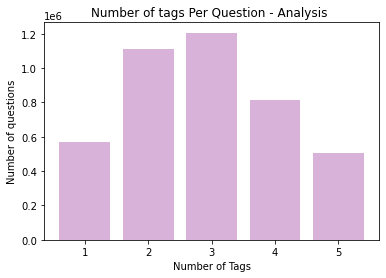

In [20]:
tagwise_count = train_Stk_Ovrfl_df.groupby('Tag Count').count()
tagwise_count = tagwise_count.reset_index()
plt.bar(tagwise_count['Tag Count'],tagwise_count['Tags'], color='purple', alpha=.3)
plt.title("Number of tags Per Question - Analysis ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

### 2.4 Tag Frequency Analysis

In [21]:
del train_Stk_Ovrfl_df['Tag Count']
train_Stk_Ovrfl_df.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [22]:
timer = datetime.now()
tag_vectorizer = CountVectorizer(tokenizer = lambda x: x.split(" "))
vectorized_Tag = tag_vectorizer.fit_transform(train_Stk_Ovrfl_df["Tags"]) #.values.astype('U'))
#tags = pd.DataFrame(tag_vectorizer.get_feature_names(), columns = ['Tag'])
print("Time taken: ", datetime.now() - timer)
#tags.info()

Time taken:  0:00:01.428329


In [23]:
total_tag_count = vectorized_Tag.shape[0]
unique_tag_count = vectorized_Tag.shape[1]
print("Total No. of Tags:", total_tag_count)
print("Total No. of unique Tags :", unique_tag_count)

Total No. of Tags: 400000
Total No. of unique Tags : 29081


In [24]:
# Tokenized Tags
individual_tags = tag_vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Invidual Tags - Example:", individual_tags[:25])

Invidual Tags - Example: ['.a', '.app', '.aspxauth', '.bash-profile', '.class-file', '.doc', '.each', '.emf', '.exe', '.hgtags', '.htaccess', '.htpasswd', '.lib', '.lrc', '.mov', '.net', '.net-1.0', '.net-1.1', '.net-2.0', '.net-3.0', '.net-3.5', '.net-4.0', '.net-4.0-beta-2', '.net-4.5', '.net-assembly']


In [25]:
tag_frequency = vectorized_Tag.sum(axis=0).A1
tag_frequency

array([3, 7, 3, ..., 1, 1, 3], dtype=int64)

In [26]:
tag_dictionary = {'Tags': individual_tags, 'Frequency': tag_frequency}
tag_frequency_df = pd.DataFrame(tag_dictionary)
tag_frequency_df.head()

,Tags,Frequency
0,.a,3
1,.app,7
2,.aspxauth,3
3,.bash-profile,10
4,.class-file,4


In [27]:
tag_frequency_df.sort_values(by=['Frequency'], inplace=True, ascending=False)
tag_frequency_df.head(10)

,Tags,Frequency
3034,c#,32055
12592,java,28265
18827,php,27079
12656,javascript,25201
852,android,22118
12965,jquery,20755
3041,c++,13745
20089,python,12950
12296,iphone,12646
1542,asp.net,12120


In [28]:
#tag_freq_df = pd.DataFrame(train_Stk_Ovrfl_df_Temp.Tags.str.split(" ").tolist(), index=train_Stk_Ovrfl_df_Temp.Id).stack()

#tag_freq_df = train_Stk_Ovrfl_df.Tags.str.split(' ').tolist()
# train_Stk_Ovrfl_df_Temp.assign(Tags=train_Stk_Ovrfl_df_Temp.Tags.str.split(' ')).explode('Tags')
#tag_freq_df = tag_freq_df.reset_index([0, 'Id'])
#tag_freq_df.columns = ['Id', 'Tag']
#tag_freq_df

In [29]:
tag_string = ''
def tag_maker(tag):
    tag_string = ' '+tag
    return tag_string

tag_string = tag_frequency_df.Tags.apply(tag_maker)
print(len(tag_string))
tag_string

42048


4337              c#
18069           java
27249            php
18157     javascript
1234         android
            ...     
29936      rbindlist
29934           rbga
29930           rbar
2925         azureus
42047        zzt-oop
Name: Tags, Length: 42048, dtype: object

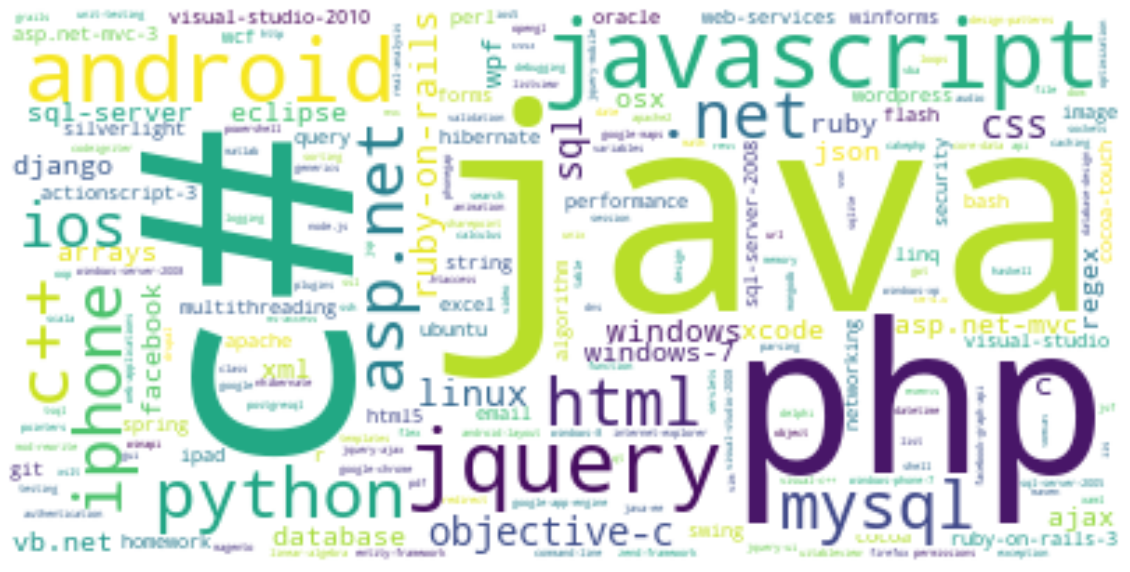

In [30]:
# Create and generate a word cloud image:
tag_count_wc = dict(zip(tag_frequency_df['Tags'], tag_frequency_df['Frequency']))
tag_count_wc = dict(tag_count_wc.items())
wordcloud = WordCloud(background_color="white").generate_from_frequencies(tag_count_wc)
plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [31]:
"""timer = datetime.now()
tag_count = train_Stk_Ovrfl_df_Temp.groupby('Tags').count()
tag_count = tag_count.reset_index()
tag_count.rename(columns={"Id": "Count"}, inplace = True)
print("Time taken: ", datetime.now() - timer)
tag_count.head(10) """

'timer = datetime.now()\ntag_count = train_Stk_Ovrfl_df_Temp.groupby(\'Tags\').count()\ntag_count = tag_count.reset_index()\ntag_count.rename(columns={"Id": "Count"}, inplace = True)\nprint("Time taken: ", datetime.now() - timer)\ntag_count.head(10) '

<Figure size 1800x1440 with 0 Axes>

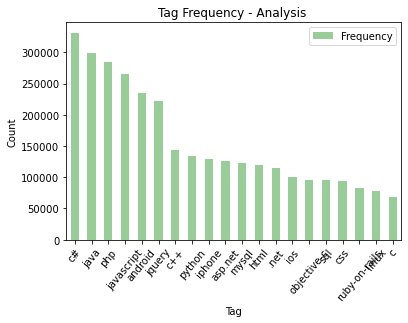

In [32]:
plt.figure(figsize=(25,20))
"""plt.bar(tag_count['Tag'],tag_count['Count'])
plt.title("Tag Frequency - Analysis ")
plt.xlabel("Tags")
plt.ylabel("Frequency")
plt.show()
"""
#['Frequency']
tag_frequency_df.head(20).plot.bar(x='Tags', y='Frequency',color='green', alpha=.4)
plt.title("Tag Frequency - Analysis ")
plt.xticks(rotation=50)
#plt.xticks(tag_count_df.index,tag_sample_df["Tag"].values)
plt.xlabel("Tag")
plt.ylabel("Count")
plt.show()

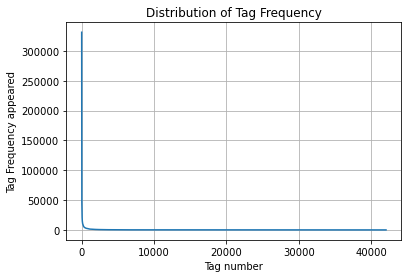

In [33]:
tag_frequency_df = tag_frequency_df.sort_values(['Frequency'], ascending=False)
plt.plot(tag_frequency_df['Frequency'].values)
plt.title("Distribution of Tag Frequency")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Tag Frequency appeared")
plt.show()

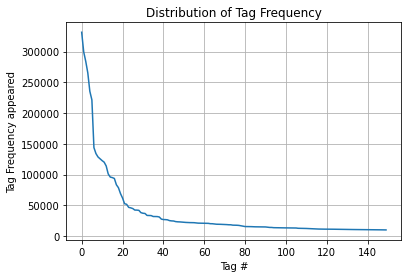

In [34]:
# tag_frequency_df = tag_frequency_df.sort_values(['Frequency'], ascending=False)
plt.plot(tag_frequency_df['Frequency'].values[0:150])
plt.title("Distribution of Tag Frequency")
plt.grid()
plt.xlabel("Tag #")
plt.ylabel("Tag Frequency appeared")
plt.show()

In [35]:
tag_top_frequency = tag_frequency_df['Frequency'].values[0:100]
print(tag_top_frequency.sum(), total_tag_count)
print("Percentage of total tags covered by first 20 tags: {}%".format(tag_top_frequency.sum()/total_tag_count*100))


5073855 4206307
Percentage of total tags covered by first 20 tags: 120.62493298753513%


In [36]:
top_n_tags = tag_frequency_df['Tags'].values[0:tag_top_frequency.shape[0]]
top_n_tags

array(['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++',
       'python', 'iphone', 'asp.net', 'mysql', 'html', '.net', 'ios',
       'objective-c', 'sql', 'css', 'ruby-on-rails', 'linux', 'c',
       'windows', 'ruby', 'sql-server', 'wpf', 'xml', 'ajax', 'regex',
       'database', 'asp.net-mvc', 'xcode', 'django', 'arrays', 'osx',
       'vb.net', 'windows-7', 'eclipse', 'json', 'facebook',
       'ruby-on-rails-3', 'string', 'performance', 'multithreading',
       'winforms', 'ubuntu', 'visual-studio-2010', 'asp.net-mvc-3',
       'image', 'html5', 'networking', 'homework', 'wordpress',
       'security', 'wcf', 'bash', 'forms', 'algorithm', 'web-services',
       'query', 'linq', 'visual-studio', 'oracle', 'git',
       'sql-server-2008', 'perl', 'r', 'spring', 'apache', 'ipad',
       'actionscript-3', 'flash', 'swing', 'silverlight', 'cocoa-touch',
       'cocoa', 'hibernate', 'excel', 'email', 'entity-framework', 'file',
       'api', 'apache2', 'jquery-ui', 'flex',

In [37]:
id_list = []
title_list = []
body_list = []
tags_list = []
# pattern = '|'.join(top_10_tags)
timer = datetime.now()
for index in train_Stk_Ovrfl_df.index:
    if bool([tag for tag in top_n_tags if(tag in train_Stk_Ovrfl_df['Tags'][index])]):
        id_list.append(train_Stk_Ovrfl_df['Id'][index])
        title_list.append(train_Stk_Ovrfl_df['Title'][index])
        body_list.append(train_Stk_Ovrfl_df['Body'][index])
        tags_list.append(train_Stk_Ovrfl_df['Tags'][index])
print("Time taken: ", datetime.now() - timer)

Time taken:  3:49:28.394354


In [38]:
train_Stk_Ovrfl_df = pd.DataFrame({'Id':id_list, 'Title':title_list, 'Body':body_list, 'Tags':tags_list})
print("Total Time taken - So far: ", datetime.now() - timer_initial)
train_Stk_Ovrfl_df.head(10)

Total Time taken - So far:  3:55:28.335849


,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents
5,6,setting proxy in active directory environment,<p>I am using a machine on which active direct...,proxy active-directory jmeter
6,7,How to draw barplot in this way with Coreplot,<p>My image is cannot post so the link is my ...,core-plot
7,8,How to fetch an XML feed using asp.net,<p>I've decided to convert a Windows Phone 7 a...,c# asp.net windows-phone-7
8,9,.NET library for generating javascript?,<p>Do you know of a .NET library for generatin...,.net javascript code-generation
9,10,"SQL Server : procedure call, inline concatenat...",<p>I'm using SQL Server 2008 R2 and was wonder...,sql variables parameters procedure calls


##### Chunk Slicing

In [39]:
train_Stk_Ovrfl_df = train_Stk_Ovrfl_df.head(chunk_size)
pickle.dump(train_Stk_Ovrfl_df, open('train_Stk_Ovrfl_df_preprocessed_3.0.pkl', 'wb'))

file = open('train_Stk_Ovrfl_df_preprocessed_3.0.pkl', 'rb')
data = pickle.load(file)
file.close()

train_Stk_Ovrfl_df = pd.DataFrame(data)
train_Stk_Ovrfl_df.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


# 3. Data Wrangling

### 3.1 Removing HTML tags

In [40]:
def html_cleanser(body):
    #body = BeautifulSoup(questions_df['Body'][0], 'html.parser').replace('\n','')
    soup = BeautifulSoup(body, 'html.parser')
    soup = soup.text.replace('\n', '')
    #soup = soup.text.replace('<p>', '')
    return soup


In [41]:
timer = datetime.now()

train_Stk_Ovrfl_df['Body'] = train_Stk_Ovrfl_df['Body'].apply(html_cleanser)

print("Time taken: ", datetime.now() - timer)

Time taken:  0:03:10.279172


### 3.2 Checking NULL values

In [42]:
train_Stk_Ovrfl_df.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,I'd like to check if an uploaded file is an im...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"In my favorite editor (vim), I regularly use c...",firefox
2,3,R Error Invalid type (list) for variable,I am import matlab file and construct a data f...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"This is probably very simple, but I simply can...",c# url encoding
4,5,How to modify whois contact details?,function modify(.......){ $mcontact = file_ge...,php api file-get-contents


In [43]:
train_Stk_Ovrfl_df.isnull().sum()

Id       0
Title    0
Body     0
Tags     0
dtype: int64

In [44]:
train_Stk_Ovrfl_df= train_Stk_Ovrfl_df.dropna()
train_Stk_Ovrfl_df.isnull().sum()

Id       0
Title    0
Body     0
Tags     0
dtype: int64

In [45]:
train_Stk_Ovrfl_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 0 to 399999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Id      400000 non-null  int64 
 1   Title   400000 non-null  object
 2   Body    400000 non-null  object
 3   Tags    400000 non-null  object
dtypes: int64(1), object(3)
memory usage: 15.3+ MB


### 3.3 Removing Emojis

In [46]:
def deEmojify(body):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',body)

In [47]:
timer = datetime.now()

train_Stk_Ovrfl_df['Body'] = train_Stk_Ovrfl_df['Body'].apply(deEmojify)


print("Time taken: ", datetime.now() - timer)
train_Stk_Ovrfl_df.head(10)

Time taken:  0:00:08.982047


,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,I'd like to check if an uploaded file is an im...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"In my favorite editor (vim), I regularly use c...",firefox
2,3,R Error Invalid type (list) for variable,I am import matlab file and construct a data f...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"This is probably very simple, but I simply can...",c# url encoding
4,5,How to modify whois contact details?,function modify(.......){ $mcontact = file_ge...,php api file-get-contents
5,6,setting proxy in active directory environment,I am using a machine on which active directory...,proxy active-directory jmeter
6,7,How to draw barplot in this way with Coreplot,My image is cannot post so the link is my pic...,core-plot
7,8,How to fetch an XML feed using asp.net,I've decided to convert a Windows Phone 7 app ...,c# asp.net windows-phone-7
8,9,.NET library for generating javascript?,Do you know of a .NET library for generating j...,.net javascript code-generation
9,10,"SQL Server : procedure call, inline concatenat...",I'm using SQL Server 2008 R2 and was wondering...,sql variables parameters procedure calls


### 3.4 Short-form Expansions

In [48]:
def text_expansion(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [49]:
timer = datetime.now()

train_Stk_Ovrfl_df['Title'] = train_Stk_Ovrfl_df['Title'].apply(lambda x: text_expansion(x))
train_Stk_Ovrfl_df['Body'] = train_Stk_Ovrfl_df['Body'].apply(lambda x: text_expansion(x))

print("Time taken: ", datetime.now() - timer)

Time taken:  0:00:39.279906


# 4. Data Wrangling using Natural Language Processing

### 4.1 NLP & Feature Engineering libraries - Import

In [50]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
volume_initializer = 3 # VOlume initializer to set size based on computing resource.

In [51]:
train_Stk_Ovrfl_df.head()

,Id,Title,Body,Tags
0,1,how to check if an uploaded file is an image w...,i would like to check if an uploaded file is a...,php image-processing file-upload upload mime-t...
1,2,how can i prevent firefox from closing when i ...,"in my favorite editor (vim), i regularly use c...",firefox
2,3,r error invalid type (list) for variable,i am import matlab file and construct a data f...,r matlab machine-learning
3,4,how do i replace special characters in a url?,"this is probably very simple, but i simply can...",c# url encoding
4,5,how to modify whois contact details?,function modify(.......){ $mcontact = file_get...,php api file-get-contents


### 4.2 Remove Stopwords

In [52]:
print('Stopword preliminary test')
sample_text = "Oh man, this is pretty cool. We will do more such things."
text_tokens = word_tokenize(sample_text)

# tokens_without_sw = [word for word in text_tokens if not word in stopwords.words('english')]
tokens_without_sw = ' '.join([word for word in text_tokens if not word in stopwords.words('english')])

print("Pre stopword removal: ", text_tokens)
print("Post stopword removal: ", tokens_without_sw)    

Stopword preliminary test
Pre stopword removal:  ['Oh', 'man', ',', 'this', 'is', 'pretty', 'cool', '.', 'We', 'will', 'do', 'more', 'such', 'things', '.']
Post stopword removal:  Oh man , pretty cool . We things .


In [53]:
def remove_stopwords(text):
    text_tokens = word_tokenize(text)
    tokens_without_sw = ' '.join([word for word in text_tokens if not word in stopwords.words('english')])
    return tokens_without_sw

In [54]:
train_Stk_Ovrfl_df.head()

,Id,Title,Body,Tags
0,1,how to check if an uploaded file is an image w...,i would like to check if an uploaded file is a...,php image-processing file-upload upload mime-t...
1,2,how can i prevent firefox from closing when i ...,"in my favorite editor (vim), i regularly use c...",firefox
2,3,r error invalid type (list) for variable,i am import matlab file and construct a data f...,r matlab machine-learning
3,4,how do i replace special characters in a url?,"this is probably very simple, but i simply can...",c# url encoding
4,5,how to modify whois contact details?,function modify(.......){ $mcontact = file_get...,php api file-get-contents


In [55]:
timer = datetime.now()
train_Stk_Ovrfl_df['Body'] = train_Stk_Ovrfl_df['Body'].apply(remove_stopwords)
print("Time taken: ", datetime.now() - timer)
train_Stk_Ovrfl_df.head()

Time taken:  6:50:01.016043


,Id,Title,Body,Tags
0,1,how to check if an uploaded file is an image w...,would like check uploaded file image file ( e....,php image-processing file-upload upload mime-t...
1,2,how can i prevent firefox from closing when i ...,"favorite editor ( vim ) , regularly use ctrl-w...",firefox
2,3,r error invalid type (list) for variable,"import matlab file construct data frame , matl...",r matlab machine-learning
3,4,how do i replace special characters in a url?,"probably simple , simply find answer : ( basic...",c# url encoding
4,5,how to modify whois contact details?,function modify ( ....... ) { $ mcontact = fil...,php api file-get-contents


In [56]:
timer = datetime.now()
train_Stk_Ovrfl_df['Title'] = train_Stk_Ovrfl_df['Title'].apply(remove_stopwords)
print("Time taken: ", datetime.now() - timer)
train_Stk_Ovrfl_df.head()

Time taken:  0:21:12.252263


,Id,Title,Body,Tags
0,1,check uploaded file image without mime type ?,would like check uploaded file image file ( e....,php image-processing file-upload upload mime-t...
1,2,prevent firefox closing press ctrl-w,"favorite editor ( vim ) , regularly use ctrl-w...",firefox
2,3,r error invalid type ( list ) variable,"import matlab file construct data frame , matl...",r matlab machine-learning
3,4,replace special characters url ?,"probably simple , simply find answer : ( basic...",c# url encoding
4,5,modify whois contact details ?,function modify ( ....... ) { $ mcontact = fil...,php api file-get-contents


### 4.3 Stemming, Lower casing & Remove Single Letters

In [57]:
def remove_single_letter(text):
    text_tokens = word_tokenize(text.lower())
    text_without_sl = ' '.join(str(stemmer.stem(word)) for word in text_tokens if  (len(word)!=1 or word =='c' or word =='C'))
    #text_without_sl = ' '.join(str(stemmer.stem(word)) for word in text_tokens)
    #' '.join(i for i in s.split() if not (i.isalpha() and len(i)==1))
    return text_without_sl

In [58]:
print("Single letter Removal - Preliminary Test")

text_ = 'Hello How are u doing?'
print("Pre: ", text_)
text_ = remove_single_letter(text_)
print("Post: ", text_)

Single letter Removal - Preliminary Test
Pre:  Hello How are u doing?
Post:  hello how are do


In [59]:
timer = datetime.now()
train_Stk_Ovrfl_df['Body'] = train_Stk_Ovrfl_df['Body'].apply(remove_single_letter)
train_Stk_Ovrfl_df['Title'] = train_Stk_Ovrfl_df['Title'].apply(remove_single_letter)
print("Time taken: ", datetime.now() - timer)
train_Stk_Ovrfl_df.head()

Time taken:  0:20:09.318429


,Id,Title,Body,Tags
0,1,check upload file imag without mime type,would like check upload file imag file e.g png...,php image-processing file-upload upload mime-t...
1,2,prevent firefox close press ctrl-w,favorit editor vim regular use ctrl-w execut c...,firefox
2,3,error invalid type list variabl,import matlab file construct data frame matlab...,r matlab machine-learning
3,4,replac special charact url,probabl simpl simpli find answer basicali want...,c# url encoding
4,5,modifi whoi contact detail,function modifi ....... mcontact file_get_cont...,php api file-get-contents


### 4.4 Clean Accented characters

In [60]:
# function to remove accented characters
def clean_accented_chars(text):
    new_text = [unicodedata.normalize('NFKD', str(x).encode('ascii', 'ignore').decode('utf-8', 'ignore')) for x in text]
    return new_text

In [61]:
timer = datetime.now()

train_Stk_Ovrfl_df['Body'] = clean_accented_chars(train_Stk_Ovrfl_df['Body'])
train_Stk_Ovrfl_df['Title'] = clean_accented_chars(train_Stk_Ovrfl_df['Title'])
train_Stk_Ovrfl_df.head()

print("Time taken: ", datetime.now() - timer)

Time taken:  0:00:02.085471


### 4.5 Remove Punctuatations

In [62]:
timer = datetime.now()

train_Stk_Ovrfl_df['Body'] = train_Stk_Ovrfl_df['Body'].str.replace('[^\w\s]','')
train_Stk_Ovrfl_df['Title'] = train_Stk_Ovrfl_df['Title'].str.replace('[^\w\s]','')
#train_Stk_Ovrfl_df['Title_Enc'] = stackoverflow_df['Title_Enc'].str.replace('[^\w\s]','')

print("Time taken: ", datetime.now() - timer)
train_Stk_Ovrfl_df.head()

Time taken:  0:00:09.624184


,Id,Title,Body,Tags
0,1,check upload file imag without mime type,would like check upload file imag file eg png ...,php image-processing file-upload upload mime-t...
1,2,prevent firefox close press ctrlw,favorit editor vim regular use ctrlw execut ce...,firefox
2,3,error invalid type list variabl,import matlab file construct data frame matlab...,r matlab machine-learning
3,4,replac special charact url,probabl simpl simpli find answer basicali want...,c# url encoding
4,5,modifi whoi contact detail,function modifi mcontact file_get_cont https...,php api file-get-contents


### 4.6 Concatenate preprocessed Title and Body columns

In [64]:
train_Stk_Ovrfl_df['Questions_ttl_bdy'] = train_Stk_Ovrfl_df['Title'] + ' ' + train_Stk_Ovrfl_df['Title'] + ' ' + train_Stk_Ovrfl_df['Body']
train_Stk_Ovrfl_df.head()

,Id,Title,Body,Tags,Questions_ttl_bdy
0,1,check upload file imag without mime type,would like check upload file imag file eg png ...,php image-processing file-upload upload mime-t...,check upload file imag without mime type check...
1,2,prevent firefox close press ctrlw,favorit editor vim regular use ctrlw execut ce...,firefox,prevent firefox close press ctrlw prevent fire...
2,3,error invalid type list variabl,import matlab file construct data frame matlab...,r matlab machine-learning,error invalid type list variabl error invalid ...
3,4,replac special charact url,probabl simpl simpli find answer basicali want...,c# url encoding,replac special charact url replac special char...
4,5,modifi whoi contact detail,function modifi mcontact file_get_cont https...,php api file-get-contents,modifi whoi contact detail modifi whoi contact...


### 4.7 Drop unwanted columns

In [65]:
del train_Stk_Ovrfl_df['Title']
del train_Stk_Ovrfl_df['Body']

In [66]:
pickle.dump(train_Stk_Ovrfl_df, open('train_Stk_Ovrfl_df_preprocessed_3.1.pkl', 'wb'))
train_Stk_Ovrfl_df.head()

,Id,Tags,Questions_ttl_bdy
0,1,php image-processing file-upload upload mime-t...,check upload file imag without mime type check...
1,2,firefox,prevent firefox close press ctrlw prevent fire...
2,3,r matlab machine-learning,error invalid type list variabl error invalid ...
3,4,c# url encoding,replac special charact url replac special char...
4,5,php api file-get-contents,modifi whoi contact detail modifi whoi contact...


In [2]:
file = open('train_Stk_Ovrfl_df_preprocessed_3.1.pkl', 'rb')
data = pickle.load(file)
file.close()

train_Stk_Ovrfl_df = pd.DataFrame(data)
train_Stk_Ovrfl_df.head()

,Id,Tags,Questions_ttl_bdy
0,1,php image-processing file-upload upload mime-t...,check upload file imag without mime type check...
1,2,firefox,prevent firefox close press ctrlw prevent fire...
2,3,r matlab machine-learning,error invalid type list variabl error invalid ...
3,4,c# url encoding,replac special charact url replac special char...
4,5,php api file-get-contents,modifi whoi contact detail modifi whoi contact...


### 4.8 Feature Engineering - Feature vector generation - using TfidfVectorizer

In [3]:
### Trying with MultiLabelBinarizer & TfidfVectorizer
feature = []

timer  = datetime.now()
vectorizer_Tfidf = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=200000)
# vectorizer_x = CountVectorizer(min_df=0.00009, max_features=200000, tokenizer=lambda x: x.split(), ngram_range=(1,4))


X_Tfidf = vectorizer_Tfidf.fit_transform(train_Stk_Ovrfl_df['Questions_ttl_bdy'])


print("Time taken: ", datetime.now() - timer)

Time taken:  0:00:25.811825


### 4.9 Label binarizing - using MultiLabelBinarizer

In [ ]:
labels = []
timer  = datetime.now()
multilabel_binarizer = MultiLabelBinarizer()
y_binarized = multilabel_binarizer.fit_transform(train_Stk_Ovrfl_df['Tags'].dropna().str.split(' '))
labels.append("MultiLabelBinarizer")
print("Time taken: ", datetime.now() - timer)


### 4.10 Test Train Split

In [ ]:
X_train_Tfidf_multilabel, X_test_Tfidf_multilabel, y_train_binarized, y_test_binarized = train_test_split(X_Tfidf, y_binarized, test_size = 0.2, random_state = 0)

print("# of data points in Tfidf based train features :", X_train_Tfidf_multilabel.shape)
print("# of data points in Tfidf based test features :", X_test_Tfidf_multilabel.shape)
print("# of data points in train data :", y_train_binarized.shape)
print("# of data points in test data :", y_test_binarized.shape)
print("Time taken: ", datetime.now() - timer)

### 4.11 Data wrangling contd. :Function to pull top n tags

In [5]:
def tag_selection(count):
    weight = y_vectorized.sum(axis=0).tolist()[0]
    sorted_tags_n = sorted(range(len(weight)), key=lambda n: weight[n], reverse=True)
    y_vectorized_=y_vectorized[:,sorted_tags_n[:count]]
    return y_vectorized_

In [6]:
# Train & test size calculation

train_total_size = train_Stk_Ovrfl_df.shape[0]
train_split_size = int(0.8*train_total_size)
test_split_size = train_total_size - train_split_size
test_split_size

80000

In [6]:
X_train = train_Stk_Ovrfl_df.head(train_split_size)
X_test = train_Stk_Ovrfl_df.tail(test_split_size)

### 4.12 Feature Extraction using N-gram & Bag of Words

In [7]:
timer  = datetime.now()

vectorizer_x = CountVectorizer(min_df=0.00009, max_features=200000, tokenizer=lambda x: x.split(), ngram_range=(1,4))
X_train_multilabel = vectorizer_x.fit_transform(X_train['Questions_ttl_bdy'])
X_test_multilabel = vectorizer_x.transform(X_test['Questions_ttl_bdy'])
feature.append("CountVectorizer")
print("Time taken: ", datetime.now() - timer)
print("# of data points in train features :", X_train_multilabel.shape)
print("# of data points in test features :", X_test_multilabel.shape)

Time taken:  0:02:59.720375
# of data points in train features : (320000, 122034)
# of data points in test features : (80000, 122034)


In [9]:
vectorizer_2 =  CountVectorizer(tokenizer = lambda x: x.split(), binary='true')

y_vectorized = vectorizer_2.fit_transform(train_Stk_Ovrfl_df['Tags'])
print(y_vectorized[:,:])
# y_vectorized.todense()

  (0, 18827)	1
  (0, 11588)	1
  (0, 8668)	1
  (0, 26575)	1
  (0, 15395)	1
  (1, 8811)	1
  (2, 20446)	1
  (2, 14834)	1
  (2, 14517)	1
  (3, 3034)	1
  (3, 26603)	1
  (3, 7679)	1
  (4, 18827)	1
  (4, 1224)	1
  (4, 8624)	1
  (5, 19859)	1
  (5, 340)	1
  (5, 12856)	1
  (6, 4920)	1
  (7, 3034)	1
  (7, 1542)	1
  (7, 28022)	1
  (8, 15)	1
  (8, 12656)	1
  (8, 4106)	1
  :	:
  (399991, 2374)	1
  (399991, 11479)	1
  (399991, 8163)	1
  (399992, 3041)	1
  (399992, 8601)	1
  (399992, 3655)	1
  (399993, 12656)	1
  (399993, 12965)	1
  (399993, 11503)	1
  (399994, 27945)	1
  (399994, 28063)	1
  (399995, 22498)	1
  (399995, 26675)	1
  (399995, 24244)	1
  (399995, 19622)	1
  (399996, 28637)	1
  (399996, 11068)	1
  (399996, 19403)	1
  (399997, 19403)	1
  (399997, 28264)	1
  (399997, 21011)	1
  (399998, 23635)	1
  (399998, 16276)	1
  (399998, 12901)	1
  (399999, 12965)	1


In [10]:
y_multilabel = tag_selection(600)
y_train = y_multilabel[0:train_split_size,:]
y_test = y_multilabel[train_split_size:train_total_size,:]
print("# of data points in train data :", y_train.shape)
print("# of data points in test data :", y_test.shape)

# of data points in train data : (320000, 600)
# of data points in test data : (80000, 600)


In [11]:
algorithm = []
accuracy = []
hamming_loss = []
precision_micro = []
precision_macro = []
recall_micro = []
recall_macro = []
f1 = []
f1_macro = []
f1_micro = []
features = []
hyperparameter = []
penalty = []

# 5. Applying Machine Learning algorithms

### 5.1 ML Algorithm - 1: OneVsRestClassifier with LogisticRegression 

##### 5.1.1 - Training & Prediction

In [12]:
timer = datetime.now()

ovsrc_classifier_1 = OneVsRestClassifier(LogisticRegression(n_jobs=-1))
ovsrc_classifier_1.fit(X_train_multilabel, y_train)
tag_predictions_1 = ovsrc_classifier_1.predict(X_test_multilabel)

algorithm.append("OvR-LogisticRegression")
features.append("Count Vectorizer")
hyperparameter.append("C=default")
penalty.append("l2")

print("Time taken: ", datetime.now() - timer)

Time taken:  1:57:11.753451


##### 5.1.2 - Accuracy & Hamming Loss

In [16]:
accuracy.append(metrics.accuracy_score(y_test, tag_predictions_1)*100)
hamming_loss.append(metrics.hamming_loss(y_test,tag_predictions_1))

print("Accuracy : {:.2f}%".format(accuracy[-1]))
print("Hamming loss: {:.4f}".format(hamming_loss[-1]))

Accuracy : 20.42%
Hamming loss: 0.0027


##### 5.1.3 - Precision, Recall & F1 Score - Micro

In [17]:
precision_micro.append(precision_score(y_test, tag_predictions_1, average='micro'))
recall_micro.append(recall_score(y_test, tag_predictions_1, average='micro'))
f1.append(f1_score(y_test, tag_predictions_1, average='micro'))

print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision_micro[-1], recall_micro[-1], f1[-1]))

Micro-average quality numbers
Precision: 0.6060, Recall: 0.4263, F1-measure: 0.5005


##### 5.1.4 - Precision, Recall & F1 Score - Macro

In [18]:
precision_macro.append(precision_score(y_test, tag_predictions_1, average='macro'))
recall_macro.append(recall_score(y_test, tag_predictions_1, average='macro'))
f1_macro.append(f1_score(y_test, tag_predictions_1, average='macro'))

print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision_macro[-1], recall_macro[-1], f1_macro[-1]))

Macro-average quality numbers
Precision: 0.4631, Recall: 0.3235, F1-measure: 0.3772


##### 5.1.5 - Classification Report

In [19]:
print (metrics.classification_report(y_test, tag_predictions_1))

              precision    recall  f1-score   support

           0       0.61      0.47      0.53      6486
           1       0.74      0.58      0.65      5566
           2       0.79      0.65      0.71      5518
           3       0.65      0.53      0.59      5033
           4       0.94      0.84      0.88      4391
           5       0.82      0.70      0.75      4245
           6       0.67      0.52      0.59      2744
           7       0.85      0.69      0.76      2581
           8       0.66      0.51      0.57      2562
           9       0.70      0.52      0.60      2428
          10       0.79      0.66      0.72      2394
          11       0.43      0.30      0.35      2317
          12       0.36      0.22      0.27      2272
          13       0.53      0.38      0.44      1886
          14       0.50      0.37      0.42      1807
          15       0.51      0.41      0.45      1849
          16       0.74      0.60      0.66      1818
          17       0.51    

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
pickle.dump(ovsrc_classifier_1, open('Ovr_LogRegression', 'wb'))

### 5.2 Hyperparameter Tuning

In [21]:
timer = datetime.now()

param_grid = dict(estimator__C=[0.001,0.01,1,100,1000])

# gsv_tuning = GridSearchCV(OneVsRestClassifier(LogisticRegression()), param_grid=param_grid, verbose=5, n_jobs=-1)
gsv_tuning = GridSearchCV(OneVsRestClassifier(LogisticRegression()), param_grid=param_grid, verbose=5, n_jobs=-1)
gsv_tuning.fit(X_train_multilabel, y_train)

print('Best hyper parameter:', gsv_tuning.best_params_)
print('Best score:', gsv_tuning.best_score_)
print("Time taken: ", datetime.now() - timer)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  25 | elapsed: 717.4min remaining: 2271.8min
[Parallel(n_jobs=-1)]: Done  12 out of  25 | elapsed: 1212.9min remaining: 1314.0min
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed: 1427.7min remaining: 555.2min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 1481.4min finished
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: C

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best hyper parameter: {'estimator__C': 1}
Best score: 0.20348125
Time taken:  1 day, 4:11:03.148502


C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
c_ = gsv_tuning.best_params_['estimator__C']
print('c_: ',c_)
print('')
print(gsv_tuning.best_estimator_)

c_:  1

OneVsRestClassifier(estimator=LogisticRegression(C=1))


### 5.3 ML Algorithm - 2: OneVsRestClassifier with Logistic Regression - Hyperparameter Tuned

##### 5.3.1 - Training & Prediction

In [23]:
timer = datetime.now()

ovsrc_classifier_2 = OneVsRestClassifier(LogisticRegression(C=c_, n_jobs=-1))
ovsrc_classifier_2.fit(X_train_multilabel, y_train)
tag_predictions_countvect = ovsrc_classifier_2.predict(X_test_multilabel)

algorithm.append("OvR-LogisticRegression")
features.append("Count Vectorizer")
hyperparameter.append("C="+str(c_))
penalty.append("l2")

print("Time taken: ", datetime.now() - timer)

Time taken:  2:00:54.854732


##### 5.3.2 - Accuracy & Hamming Loss

In [24]:
accuracy.append(metrics.accuracy_score(y_test, tag_predictions_countvect)*100)
hamming_loss.append(metrics.hamming_loss(y_test,tag_predictions_countvect))

print("Accuracy : {:.2f}%".format(accuracy[-1]))
print("Hamming loss: {:.4f}".format(hamming_loss[-1]))

Accuracy : 20.42%
Hamming loss: 0.0027


##### 5.3.3 - Precision, Recall & F1 Score - Micro

In [25]:
precision_micro.append(precision_score(y_test, tag_predictions_countvect, average='micro'))
recall_micro.append(recall_score(y_test, tag_predictions_countvect, average='micro'))
f1.append(f1_score(y_test, tag_predictions_countvect, average='micro'))

print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision_micro[-1], recall_micro[-1], f1[-1]))

Micro-average quality numbers
Precision: 0.6060, Recall: 0.4263, F1-measure: 0.5005


##### 5.3.4 - Precision, Recall & F1 Score - Macro

In [26]:
precision_macro.append(precision_score(y_test, tag_predictions_countvect, average='macro'))
recall_macro.append(recall_score(y_test, tag_predictions_countvect, average='macro'))
f1_macro.append(f1_score(y_test, tag_predictions_countvect, average='macro'))

print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision_macro[-1], recall_macro[-1], f1_macro[-1]))

Macro-average quality numbers
Precision: 0.4631, Recall: 0.3235, F1-measure: 0.3772


##### 5.3.5 - Classification Report

In [27]:
print (metrics.classification_report(y_test, tag_predictions_countvect))

              precision    recall  f1-score   support

           0       0.61      0.47      0.53      6486
           1       0.74      0.58      0.65      5566
           2       0.79      0.65      0.71      5518
           3       0.65      0.53      0.59      5033
           4       0.94      0.84      0.88      4391
           5       0.82      0.70      0.75      4245
           6       0.67      0.52      0.59      2744
           7       0.85      0.69      0.76      2581
           8       0.66      0.51      0.57      2562
           9       0.70      0.52      0.60      2428
          10       0.79      0.66      0.72      2394
          11       0.43      0.30      0.35      2317
          12       0.36      0.22      0.27      2272
          13       0.53      0.38      0.44      1886
          14       0.50      0.37      0.42      1807
          15       0.51      0.41      0.45      1849
          16       0.74      0.60      0.66      1818
          17       0.51    

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
pickle.dump(ovsrc_classifier_2, open('Ovr_LogRegression_hyperparamter_tuned', 'wb'))

### 5.4 ML Algorithm - 3: OneVsRestClassifier with Logistic Regression using 'sag' solver

##### 5.4.1 - Training & Prediction

In [69]:
timer = datetime.now()

ovsrc_classifier_3 = OneVsRestClassifier(LogisticRegression(solver='sag', penalty='l2', max_iter=100, n_jobs=-1))
ovsrc_classifier_3.fit(X_train_multilabel, y_train)
tag_predictions_countvect = ovsrc_classifier_3.predict(X_test_multilabel)

algorithm.append("OvR-LogisticRegression")
features.append("Count Vectorizer")
hyperparameter.append("solver='sag'")
penalty.append("l2")

print("Time taken: ", datetime.now() - timer)

C:\Users\sujau\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Time taken:  8:08:23.491851


##### 5.4.2 - Accuracy & Hamming Loss

In [70]:
accuracy.append(metrics.accuracy_score(y_test, tag_predictions_countvect)*100)
hamming_loss.append(metrics.hamming_loss(y_test,tag_predictions_countvect))

print("Accuracy : {:.2f}%".format(accuracy[-1]))
print("Hamming loss: {:.4f}".format(hamming_loss[-1]))

Accuracy : 8.76%
Hamming loss: 0.0031


##### 5.4.3 - Precision, Recall & F1 Score - Micro

In [71]:
precision_micro.append(precision_score(y_test, tag_predictions_countvect, average='micro'))
recall_micro.append(recall_score(y_test, tag_predictions_countvect, average='micro'))
f1.append(f1_score(y_test, tag_predictions_countvect, average='micro'))

print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision_micro[-1], recall_micro[-1], f1[-1]))

Micro-average quality numbers
Precision: 0.7912, Recall: 0.0178, F1-measure: 0.0349


##### 5.4.4 - Precision, Recall & F1 Score - Macro

In [72]:
precision_macro.append(precision_score(y_test, tag_predictions_countvect, average='macro'))
recall_macro.append(recall_score(y_test, tag_predictions_countvect, average='macro'))
f1_macro.append(f1_score(y_test, tag_predictions_countvect, average='macro'))

print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision_macro[-1], recall_macro[-1], f1_macro[-1]))

Macro-average quality numbers
Precision: 0.0360, Recall: 0.0011, F1-measure: 0.0020


C:\Users\sujau\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### 5.4.5 - Classification Report

In [73]:
print (metrics.classification_report(y_test, tag_predictions_countvect))

              precision    recall  f1-score   support

           0       0.38      0.00      0.01      6486
           1       0.77      0.06      0.12      5566
           2       0.84      0.08      0.15      5518
           3       0.59      0.04      0.08      5033
           4       0.97      0.20      0.33      4391
           5       0.75      0.12      0.21      4245
           6       0.69      0.02      0.03      2744
           7       0.89      0.01      0.03      2581
           8       0.82      0.00      0.01      2562
           9       0.83      0.00      0.01      2428
          10       0.92      0.01      0.03      2394
          11       0.52      0.02      0.04      2317
          12       1.00      0.00      0.00      2272
          13       1.00      0.00      0.00      1886
          14       0.00      0.00      0.00      1807
          15       0.50      0.00      0.00      1849
          16       0.73      0.04      0.08      1818
          17       1.00    

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5.5 Save the model

In [74]:
pickle.dump(ovsrc_classifier_3, open('Ovr_LogRegression_saga_solver', 'wb'))

### 5.6 ML Algorithm - 4: OneVsRestClassifier with SGD Classifier

##### 5.6.1 - Training & Prediction

In [85]:
timer = datetime.now()
features.append("Count Vectorizer")
hyperparameter.append("alpha=0.0001")
algorithm.append("OvR-SGDClassifier")
penalty.append('l2')
classifier_sgd = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.0001, penalty='l2', n_jobs=-1))
classifier_sgd.fit(X_train_multilabel, y_train)
predictions_sgd = classifier_sgd.predict (X_test_multilabel)

##### 5.6.2 - Accuracy & Hamming Loss

In [90]:
accuracy.append(metrics.accuracy_score(y_test, predictions_sgd)*100)
hamming_loss.append(metrics.hamming_loss(y_test, predictions_sgd))

print("Accuracy : {:.2f}%".format(accuracy[-1]))
print("Hamming loss: {:.4f}".format(hamming_loss[-1]))

Accuracy : 20.71%
Hamming loss: 0.0027


##### 5.6.3 - Precision, Recall & F1 Score - Micro

In [96]:
precision_micro.append(precision_score(y_test, predictions_sgd, average='micro'))
recall_micro.append(recall_score(y_test, predictions_sgd, average='micro'))
f1.append(f1_score(y_test, predictions_sgd, average='micro'))

print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision_micro[-1], recall_micro[-1], f1[-1]))

Micro-average quality numbers
Precision: 0.6286, Recall: 0.4048, F1-measure: 0.4925


##### 5.6.4 - Precision, Recall & F1 Score - Macro

In [97]:
precision_macro.append(precision_score(y_test, predictions_sgd, average='macro'))
recall_macro.append(recall_score(y_test, predictions_sgd, average='macro'))
f1_macro.append(f1_score(y_test, predictions_sgd, average='macro'))

print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision_macro[-1], recall_macro[-1], f1_macro[-1]))
print("Time taken: ", datetime.now() - timer)

Macro-average quality numbers
Precision: 0.4855, Recall: 0.3080, F1-measure: 0.3658
Time taken:  0:22:56.782037


##### 5.6.5 - Classification Report

In [98]:
print (metrics.classification_report(y_test, predictions_sgd))

              precision    recall  f1-score   support

           0       0.66      0.40      0.50      6486
           1       0.73      0.56      0.64      5566
           2       0.77      0.63      0.69      5518
           3       0.69      0.48      0.57      5033
           4       0.90      0.82      0.86      4391
           5       0.81      0.67      0.73      4245
           6       0.68      0.45      0.54      2744
           7       0.81      0.69      0.74      2581
           8       0.69      0.48      0.57      2562
           9       0.67      0.50      0.57      2428
          10       0.77      0.64      0.70      2394
          11       0.42      0.25      0.31      2317
          12       0.39      0.18      0.25      2272
          13       0.57      0.32      0.41      1886
          14       0.50      0.31      0.38      1807
          15       0.48      0.38      0.42      1849
          16       0.72      0.57      0.63      1818
          17       0.56    

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sujau\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5.7 - SGD Calssifier - Hyperparameter Tuning

param_grid_sgd :  {'estimator__alpha': [1e-05], 'estimator__loss': ['hinge'], 'estimator__penalty': ['l2']}
param_grid_sgd :  {'estimator__alpha': [0.0001], 'estimator__loss': ['hinge'], 'estimator__penalty': ['l2']}
param_grid_sgd :  {'estimator__alpha': [0.001], 'estimator__loss': ['hinge'], 'estimator__penalty': ['l2']}
param_grid_sgd :  {'estimator__alpha': [0.01], 'estimator__loss': ['hinge'], 'estimator__penalty': ['l2']}
param_grid_sgd :  {'estimator__alpha': [0.1], 'estimator__loss': ['hinge'], 'estimator__penalty': ['l2']}

 The optimal value of alpha with penalty=l2 and loss= log is : 1e-05


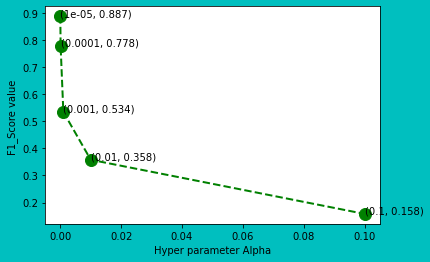

Optimal sgd alpha:  1e-05
Time taken:  2:27:41.500467


In [105]:
timer = datetime.now()
import warnings
warnings.filterwarnings('ignore')

cv_sgd_scores = []
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1]

for i in alpha: 
    # print("alpha: ", i)
    param_grid_sgd = {'estimator__alpha':[i], 
                      'estimator__loss':['hinge'],
                      'estimator__penalty':['l2']}
    
    print("param_grid_sgd : ", param_grid_sgd)
    
    classifier = OneVsRestClassifier(SGDClassifier())

    model_sgd =GridSearchCV(classifier,
                          param_grid_sgd,
                          cv=3,
                          scoring='f1_micro',
                          n_jobs=-1)
    
    best_model_sgd = model_sgd.fit(X_train_multilabel, y_train)

    model_sgd_score = best_model_sgd.score(X_train_multilabel,  y_train)
        
    cv_sgd_scores.append(model_sgd_score.mean())


f_score_sgd = [x for x in cv_sgd_scores]

# determining Optimal alpha
optimal_sgd_alpha = alpha[f_score_sgd.index(max(f_score_sgd))]

print("The optimal alpha with penalty='l2' and loss='hinge' is :", optimal_sgd_alpha)

# Plots
fig = plt.figure(facecolor='c', edgecolor='k')
plt.plot(alpha, f_score_sgd, color='green', marker='o', linestyle='dashed',linewidth=2, markersize=12)

for xy in zip(alpha, np.round(f_score_sgd,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Hyper parameter Alpha')
plt.ylabel('F1_Score value ')
plt.show()
print("Optimal sgd alpha: ", optimal_sgd_alpha)
print("Time taken: ", datetime.now() - timer)


### 5.8 ML Algorithm - 5: OneVsRestClassifier - SGD Classifier - HyperParameter C tuned

In [111]:
timer = datetime.now()

features.append("Count Vectorizer")
hyperparameter.append("alpha="+str(optimal_sgd_alpha))
algorithm.append("OvR-SGDClassifier")
penalty.append('l2')

classifier_sgd = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=optimal_sgd_alpha, penalty='l2', n_jobs=-1))
classifier_sgd.fit(X_train_multilabel, y_train)
predictions_sgd = classifier_sgd.predict (X_test_multilabel)

#Accuracy calculation
accuracy.append(metrics.accuracy_score(y_test, predictions_sgd)*100)
hamming_loss.append(metrics.hamming_loss(y_test, predictions_sgd))

print("Accuracy : {:.2f}%".format(accuracy[-1]))
print("Hamming loss: {:.4f}".format(hamming_loss[-1]))

# Precision, Recall, f1 - Micro - calculation
precision_micro.append(precision_score(y_test, predictions_sgd, average='micro'))
recall_micro.append(recall_score(y_test, predictions_sgd, average='micro'))
f1.append(f1_score(y_test, predictions_sgd, average='micro'))
print()
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision_micro[-1], recall_micro[-1], f1[-1]))

# Precision, Recall, f1 - Macro - calculation
precision_macro.append(precision_score(y_test, predictions_sgd, average='macro'))
recall_macro.append(recall_score(y_test, predictions_sgd, average='macro'))
f1_macro.append(f1_score(y_test, predictions_sgd, average='macro'))
print()
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision_macro[-1], recall_macro[-1], f1_macro[-1]))

print()
print("Time taken: ", datetime.now() - timer)

Accuracy : 16.55%
Hamming loss: 0.0033

Micro-average quality numbers
Precision: 0.4854, Recall: 0.4315, F1-measure: 0.4569

Macro-average quality numbers
Precision: 0.3941, Recall: 0.3452, F1-measure: 0.3646

Time taken:  0:25:09.055064


### 5.9 ML Algorithm - 6: OneVsRestClassifier - SGD Classifier - Penalty = l1

In [79]:
timer = datetime.now()
features.append("Count Vectorizer")
hyperparameter.append("alpha=0.0001")
algorithm.append("OvR-SGDClassifier")
penalty.append('l1')
classifier_sgd = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.0001, penalty='l1', n_jobs=-1))
classifier_sgd.fit(X_train_multilabel, y_train)
predictions_sgd = classifier_sgd.predict (X_test_multilabel)

C:\Users\sujau\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


In [80]:
#Accuracy calculation
accuracy.append(metrics.accuracy_score(y_test, predictions_sgd)*100)
hamming_loss.append(metrics.hamming_loss(y_test, predictions_sgd))

print("Accuracy : {:.2f}%".format(accuracy[-1]))
print("Hamming loss: {:.4f}".format(hamming_loss[-1]))

# Precision, Recall, f1 - Micro - calculation
precision_micro.append(precision_score(y_test, predictions_sgd, average='micro'))
recall_micro.append(recall_score(y_test, predictions_sgd, average='micro'))
f1.append(f1_score(y_test, predictions_sgd, average='micro'))
print()
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision_micro[-1], recall_micro[-1], f1[-1]))

# Precision, Recall, f1 - Macro - calculation
precision_macro.append(precision_score(y_test, predictions_sgd, average='macro'))
recall_macro.append(recall_score(y_test, predictions_sgd, average='macro'))
f1_macro.append(f1_score(y_test, predictions_sgd, average='macro'))
print()
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision_macro[-1], recall_macro[-1], f1_macro[-1]))

print()
print("Time taken: ", datetime.now() - timer)

Accuracy : 13.40%
Hamming loss: 0.0034

Micro-average quality numbers
Precision: 0.4623, Recall: 0.4453, F1-measure: 0.4537

Macro-average quality numbers
Precision: 0.3308, Recall: 0.3469, F1-measure: 0.3287

Time taken:  1:55:16.539125


### 5.10 Tag Predictions - Metrics [Machine Learning Models]

In [81]:
ml_index = range(len(algorithm))
tag_prediction_metrics = pd.DataFrame({'Algorithm':algorithm,
                                       'Feature Process':features,
                                       'Penalty': penalty,
                                       'Hyperparameter': hyperparameter,
                                       'Accuracy':accuracy,
                                       'Hamming loss': hamming_loss,
                                       'Precision': precision_micro,
                                       'Recall': recall_micro,
                                       'F1 Score': f1
                                      })

print("")
print("Tag Prediction Metrics - Summary:")

ml = PrettyTable()

ml.field_names = ["Algorithm",
                  "Feature Process",
                  "Penalty",
                  "Hyperparameter",
                  "Accuracy",
                  "Hamming loss",
                  "Precision",
                  "Recall",
                  "F1 Score"]

#ml._max_width = {"Algorithm" : 10,  "Accuracy" : 5, "Ham. loss" : 5, 
#                 
#                 "Precision-Macro" : 5, "Recall-Macro" : 5, "F1 Macro" : 5}
for index in tag_prediction_metrics.index:
    ml.add_row([tag_prediction_metrics["Algorithm"][index],
                tag_prediction_metrics["Feature Process"][index],
                tag_prediction_metrics["Penalty"][index],
                tag_prediction_metrics["Hyperparameter"][index],
                round(tag_prediction_metrics["Accuracy"][index],2),
                round(tag_prediction_metrics["Hamming loss"][index],4),
                round(tag_prediction_metrics["Precision"][index],2),
                round(tag_prediction_metrics["Recall"][index],2),
                round(tag_prediction_metrics["F1 Score"][index],2)])


# ml.sortby = "Accuracy"
# ml.reversesort = True
print(ml)
print("")
#print("Total Time taken: ", datetime.now() - timer_initial)


Tag Prediction Metrics - Summary:
+--------------------+------------------+---------+----------------+----------+--------------+-----------+--------+----------+
|     Algorithm      | Feature Process  | Penalty | Hyperparameter | Accuracy | Hamming loss | Precision | Recall | F1 Score |
+--------------------+------------------+---------+----------------+----------+--------------+-----------+--------+----------+
| OvR-Log.Regression | Count Vectorizer |    l2   |   C=default    |  20.42   |    0.0027    |    0.61   |  0.43  |   0.5    |
| OvR-Log.Regression | Count Vectorizer |    l2   |      C=1       |  20.42   |    0.0027    |    0.61   |  0.43  |   0.5    |
| OvR-SGDClassifier  | Count Vectorizer |    l2   |  alpha=0.0001  |  20.71   |    0.0027    |    0.63   |  0.4   |   0.49   |
| OvR-SGDClassifier  | Count Vectorizer |    l2   | alpha=0.00001  |  16.55   |    0.0033    |    0.49   |  0.43  |   0.46   |
| OvR-Log.Regression | Count Vectorizer |    l2   |  solver='sag'  |   8.76 

In [83]:
pickle.dump(tag_prediction_metrics, open('tag_prediction_metrics.pkl', 'wb'))

In [18]:
file = open('tag_prediction_metrics.pkl', 'rb')
tag_prediction_metrics = pickle.load(file)
file.close()

type(tag_prediction_metrics)
tag_prediction_metrics.index

RangeIndex(start=0, stop=6, step=1)

### 5.11 Deep Learning Algorithm - 1: Keras - Sequential Model

In [6]:
timer = datetime.now()

question_len_list = []
for question in train_Stk_Ovrfl_df['Questions_ttl_bdy']:
    question_len_list.append(len(word_tokenize(question)))
train_question_length = max(question_len_list)
print("Train question length: ",train_question_length)

print("Time taken: ", datetime.now() - timer)

Question max quantiled length:  347


In [6]:
QUESTIONS_VOCAB_SIZE = int(np.quantile(question_len_list,0.98))
print("Question max quantiled length: ",QUESTIONS_VOCAB_SIZE)

Question max quantiled length:  347


##### 5.11.1 - Feature Transformation

In [7]:
timer = datetime.now()

question_tokenizer = text.Tokenizer(num_words=train_question_length)
question_tokenizer.fit_on_texts(train_set['Questions_ttl_bdy'])

BoW_train = question_tokenizer.texts_to_matrix(train_set['Questions_ttl_bdy'])
BoW_test = question_tokenizer.texts_to_matrix(test_set['Questions_ttl_bdy'])

print("Time taken: ", datetime.now() - timer)

Time taken:  0:00:54.996980


##### 5.11.2 - Label Transformation

In [8]:
# NUM_OF_TAGS = 250

tags_split = [tag.split(' ') for tag in train_Stk_Ovrfl_df['Tags'].values]

In [9]:
tags_split

[['php', 'image-processing', 'file-upload', 'upload', 'mime-types'],
 ['firefox'],
 ['r', 'matlab', 'machine-learning'],
 ['c#', 'url', 'encoding'],
 ['php', 'api', 'file-get-contents'],
 ['proxy', 'active-directory', 'jmeter'],
 ['core-plot'],
 ['c#', 'asp.net', 'windows-phone-7'],
 ['.net', 'javascript', 'code-generation'],
 ['sql', 'variables', 'parameters', 'procedure', 'calls'],
 ['.net', 'obfuscation', 'reflector'],
 ['algorithm', 'language-agnostic', 'random'],
 ['postfix', 'migration', 'mdaemon'],
 ['documentation', 'latex3', 'expl3'],
 ['windows-7'],
 ['php', 'url-routing', 'conventions'],
 ['r', 'temporary-files'],
 ['wpf', 'binding'],
 ['javascript', 'code-generation', 'playframework', 'minify'],
 ['php', 'xml', 'hash', 'multidimensional-array', 'simplexml-load-string'],
 ['medical-science', 'cancer', 'healthcare'],
 ['c#', '.net', 'linq'],
 ['actionscript-3', 'flex', 'flex3'],
 ['c#', 'linq', 'string', 'enumeration'],
 ['visual-studio', 'makefile', 'gnu'],
 ['html', 'semant

In [10]:
timer = datetime.now()

multitag_encoder  = MultiLabelBinarizer()
multitag_encoded = multitag_encoder.fit_transform(tags_split)
tags = multitag_encoder.classes_
print("Time taken: ", datetime.now() - timer)
tags

Time taken:  0:00:01.307289


array(['.a', '.app', '.aspxauth', ..., 'zxspectrum', 'zypper', 'zyxel'],
      dtype=object)

##### 5.11.3 - Test - Train Split

In [12]:
timer = datetime.now()

train_tag_set, test_tag_set = train_test_split(multitag_encoded, test_size = 0.20)
train_tag_set.shape, test_tag_set.shape

print("Time taken: ", datetime.now() - timer)

Time taken:  0:04:05.642557


In [13]:
unique, counts = np.unique(tags, return_counts=True)

unique_tags = sum(counts)
unique_tags

29081

##### 5.11.4 - Model Build

In [16]:
timer = datetime.now()

seq_model = tf.keras.models.Sequential()
seq_model.add(tf.keras.layers.Dense(100, input_shape=(train_question_length,), activation='relu'))
#seq_model.add(tf.keras.layers.Dense(100, input_shape=(train_question_length,), activation='relu'))
seq_model.add(tf.keras.layers.Dense(50, activation='relu'))
seq_model.add(tf.keras.layers.Dense(unique_tags, activation='sigmoid'))

seq_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("Time taken: ", datetime.now() - timer)

Time taken:  0:00:00.071016


##### 5.11.5 - Model Training

In [17]:
timer = datetime.now()

seq_model.fit(BoW_train, train_tag_set, epochs=10, batch_size=250, validation_split=0.1, verbose=1)


print("Time taken: ", datetime.now() - timer)

Epoch 1/10
1152/1152 [==============================] - 87s 76ms/step - loss: 0.0156 - accuracy: 0.0338 - val_loss: 9.3160e-04 - val_accuracy: 0.0262
Epoch 2/10
1152/1152 [==============================] - 59s 51ms/step - loss: 8.2577e-04 - accuracy: 0.0342 - val_loss: 7.8195e-04 - val_accuracy: 0.0231
Epoch 3/10
1152/1152 [==============================] - 62s 54ms/step - loss: 7.6415e-04 - accuracy: 0.0343 - val_loss: 7.6006e-04 - val_accuracy: 0.0464
Epoch 4/10
1152/1152 [==============================] - 63s 54ms/step - loss: 7.5238e-04 - accuracy: 0.0345 - val_loss: 7.5416e-04 - val_accuracy: 0.0464
Epoch 5/10
1152/1152 [==============================] - 64s 55ms/step - loss: 7.4987e-04 - accuracy: 0.0343 - val_loss: 7.5299e-04 - val_accuracy: 0.0464
Epoch 6/10
1152/1152 [==============================] - 62s 54ms/step - loss: 7.4881e-04 - accuracy: 0.0349 - val_loss: 7.5152e-04 - val_accuracy: 0.0464
Epoch 7/10
1152/1152 [==============================] - 63s 55ms/step - loss: 7.

##### 5.11.6 - Model Evaluation

In [21]:
seq_nn_scores = seq_model.evaluate(BoW_test, test_tag_set, batch_size=250, verbose=1)
# seq_model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (seq_model.metrics_names[1], seq_nn_scores[1]*100))

320/320 [==============================] - 9s 30ms/step - loss: 7.4861e-04 - accuracy: 0.0456
accuracy: 4.56%


In [48]:
new_row = {"Algorithm":"NN-Sequential",
           "Feature Process": "Keras Tokenizer",
           "Accuracy": seq_nn_scores[1]*100,
           "Hamming loss":seq_nn_scores[0]
          }

In [21]:
tag_prediction_metrics = tag_prediction_metrics.append(new_row, ignore_index=True)

In [23]:
pickle.dump(tag_prediction_metrics, open('tag_prediction_metrics.pkl', 'wb'))

In [24]:
file = open('tag_prediction_metrics.pkl', 'rb')
tag_prediction_metrics = pickle.load(file)
file.close()


tag_prediction_metrics.index

RangeIndex(start=0, stop=7, step=1)

### 5.12 Tag Prediction Metrics [Machine Learning & Deep Learning Models]

In [51]:

for index in tag_prediction_metrics.index:
    ml.add_row([tag_prediction_metrics["Algorithm"][index],
                tag_prediction_metrics["Feature Process"][index],
                tag_prediction_metrics["Penalty"][index],
                tag_prediction_metrics["Hyperparameter"][index],
                round(tag_prediction_metrics["Accuracy"][index],2),
                round(tag_prediction_metrics["Hamming loss"][index],4),
                round(tag_prediction_metrics["Precision"][index],2),
                round(tag_prediction_metrics["Recall"][index],2),
                round(tag_prediction_metrics["F1 Score"][index],2)])


# ml.sortby = "Accuracy"
# ml.reversesort = True
print(ml)
print("")
#print("Total Time taken: ", datetime.now() - timer_initial)

Tag Prediction Metrics - Summary:
+--------------------+------------------+---------+----------------+----------+--------------+-----------+--------+----------+
|     Algorithm      | Feature Process  | Penalty | Hyperparameter | Accuracy | Hamming loss | Precision | Recall | F1 Score |
+--------------------+------------------+---------+----------------+----------+--------------+-----------+--------+----------+
| OvR-Log.Regression | Count Vectorizer |    l2   |   C=default    |  20.42   |    0.0027    |    0.61   |  0.43  |   0.5    |
| OvR-Log.Regression | Count Vectorizer |    l2   |      C=1       |  20.42   |    0.0027    |    0.61   |  0.43  |   0.5    |
| OvR-SGDClassifier  | Count Vectorizer |    l2   |  alpha=0.0001  |  20.71   |    0.0027    |    0.63   |  0.4   |   0.49   |
| OvR-SGDClassifier  | Count Vectorizer |    l2   | alpha=0.00001  |  16.55   |    0.0033    |    0.49   |  0.43  |   0.46   |
| OvR-Log.Regression | Count Vectorizer |    l2   |  solver='sag'  |   8.76  